# FAA Database Query

## This python script lets you request data from the FAA database in a simple way and allows you to visualize it

#### Set up the query

In [1]:
import requests

data_atrs = {
    'keylist':'LOCID%2CYYYYMM',
    'line': '',
    'cmd' : 'tot',
    'avgdays': '1'
    }
line_atrs  = {
    'start_date' : '', #YYYYMM
    'end_date' : '', #YYYYMM
    'airports' : '' #ATL%27%2C%27+BOS%27%2C%27+...+SLC%27%2C%27+TPA

    }

#### Enter the parameters for the data you want

In [2]:
line_atrs['start_date'] = input('enter start date in yyyymm format: ')
line_atrs['end_date'] = input('enter end date in yyyymm format: ')

airports = input('enter aiport 3 letter codes in all caps with space in between: ').split(' ')


enter start date in yyyymm format: 202001
enter end date in yyyymm format: 202004
enter aiport 3 letter coces in all caps with space in between: SFO LAX IAD


#### Format query and request data

In [3]:
line_atrs['airports'] = ''
for airport in airports:
    line_atrs['airports']+=airport+'%27%2C%27+'

line_atrs['airports'] = line_atrs['airports'][:-10]

data_atrs['line'] = 'SELECT+LOCID%2CYYYYMM+FROM+OPSNETSUMS+WHERE+YYYYMM%3E%3D{}+AND+YYYYMM%3C%3D{}+AND+LOCID+IN+%28%27+{}+%27%29+GROUP+BY+LOCID%2CYYYYMM+ORDER+BY+LOCID%2CYYYYMM'
data_atrs['line'] = data_atrs['line'].format(line_atrs['start_date'],line_atrs['end_date'],line_atrs['airports'])


data_param = ''
for atr in data_atrs:
    data_param+=atr+'='+data_atrs[atr]+'&'

headers = { 
        'Content-Type': 'application/x-www-form-urlencoded'
    }

print('sending request...')

r = requests.post('https://aspm.faa.gov/tfms/sys/tfms-server-x.asp', headers=headers,data= data_param)
print('response: '+ str(r))


sending request...
response: <Response [200]>


#### Display data in a table

In [4]:
import pandas as pd
from bs4 import BeautifulSoup as bs
import numpy as np

raw_html_data = str(r.content)

soup = bs(raw_html_data, 'html.parser')



raw_data = soup.find_all('tr')[3:-5]

airports_index = {}

apt = raw_data[0].findChildren()[1].text.strip()
start = 0

for i in range(1,len(raw_data)):
    if(apt == raw_data[i].findChildren()[1].text.strip()):
        continue
    airports_index[apt]= '{}:{}'.format(start,i)
    apt = raw_data[i].findChildren()[1].text.strip()
    start = i
    
airports_index[apt]= '{}:{}'.format(start,len(raw_data))


data_headers = []

for child in soup.find_all('tr')[1].findChildren('td'):
    if child.text.isalpha():
        data_headers.append(child.text)
data_headers=data_headers[1:]

airports_data = {}


for apt in airports_index:
    data = []
    idx = airports_index[apt].split(':')
    for row in raw_data[int(idx[0]):int(idx[1])]:
        children = row.findChildren()
        row_data = [children[4].text,children[12].text,children[20].text,children[23].text]
        data.append(row_data)

    airports_data[apt] = pd.DataFrame(data= data, columns=data_headers)

    print('\nAirport: {}'.format(apt))
    print(airports_data[apt])


Airport: IAD - Washington
      Date Departure Arrival TotalOperations
0  01/2020    11,688  11,632          23,320
1  02/2020    11,513  11,461          22,974
2  03/2020    10,186  10,141          20,327
3  04/2020     3,683   3,626           7,309

Airport: LAX - Los Angeles
      Date Departure Arrival TotalOperations
0  01/2020    27,901  27,847          55,748
1  02/2020    25,508  25,458          50,966
2  03/2020    23,419  23,363          46,782
3  04/2020     7,766   7,726          15,492

Airport: SFO - San Francisco
      Date Departure Arrival TotalOperations
0  01/2020    18,502  18,425          36,927
1  02/2020    17,251  17,172          34,423
2  03/2020    14,990  14,924          29,914
3  04/2020     3,996   3,886           7,882


#### Display data in a chart

enter which category to plot: Arrival
Airport: IAD - Washington


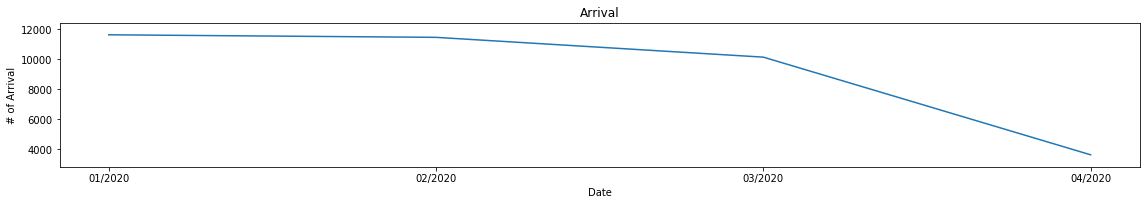

Airport: LAX - Los Angeles


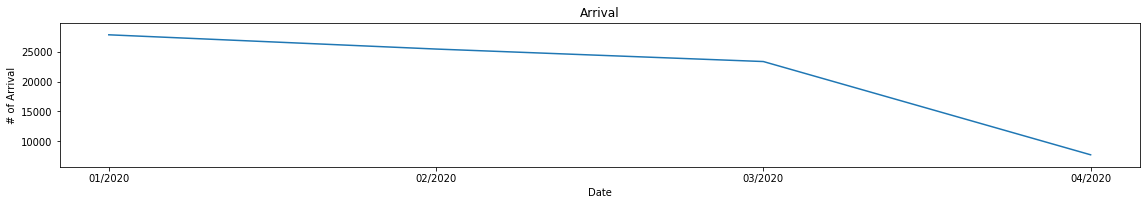

Airport: SFO - San Francisco


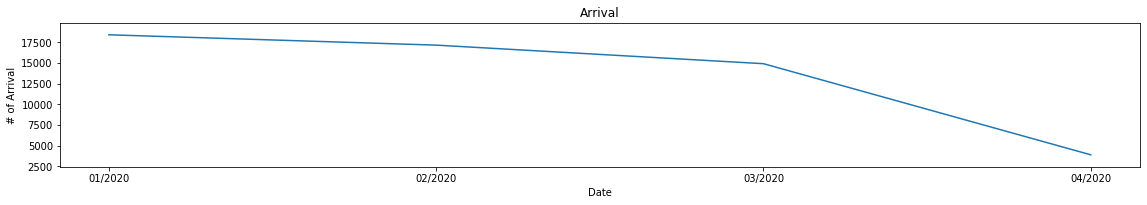

In [5]:
from matplotlib import pyplot as plt
from matplotlib import axes

cat = input('enter which category to plot: ')

for apt in airports_data:
    
    fig = plt.figure(figsize=(15,2))
    axes=fig.add_axes([0,0,1,1])

    print('Airport: {}'.format(apt))
    df = airports_data[apt]
    
    axes.set_title(cat)

    plt.xlabel('Date')
    plt.ylabel('# of {}'.format(cat))
        
    vals = []
        
    for val in df[cat]:
        vals.append(int(val.replace(',','')))

    low = min(vals)
    high = max(vals)
        
    rng =  high - low
    axes.set_ylim(ymin=int(low - rng * .1),ymax=int(high + rng * .1))
    
    frq = 10

    step = max(int(len(df['Date'])/frq),1)
    tck=range(0,len(df['Date']),step)
    
    tck_dates = []
    for i in tck:
        tck_dates.append(df['Date'][i])
    plt.xticks(tck,tck_dates)
    

    axes.plot(df['Date'],vals)
        
    plt.show()